# Host dimension

In this dimension we hold information relative to airbnb hosts.

![Host schema](../images/host_schema.jpg)


Comparing the schema proposed in phase I to the one we currently have, the main difference is that we changed the data type of the `host_since` column. The initial idea was that it would be the date of the host's registration in the airbnb platform, but since dimension tables' data is typically categorical, we changed this field to `membership_duration`.

### Hierarchies and data granularity

The only hierarchical relationship in this dimension is `country` < `continent`. There wasn't a way to make it more fine-grained since the host location data we had was quite heterogenous, more often than not cointaining only the host's country.

### Extraction, Transformation, Loading

![ETL Host](../images/ETL_host.jpg)

In [15]:
# Libraries
import psycopg2 as pg
import pandas as pd
import os
import re
import pycountry_convert as pc
import matplotlib.pyplot as plt
import datetime
import math
import numpy as np
import psycopg2.extras
import seaborn as sns
import pandas.io.sql as sqlio

## Read csv files

In [74]:
# Main dataset
df = pd.read_csv("../data/listings_al.csv")
# Dataset for countries gdp.
# Source:  https://data.worldbank.org/indicator/ny.gdp.pcap.cd
df_gdp = pd.read_csv('../data/GDP per capita (worldbank).csv')

## EDA and missing data

Singling out the columns of interest for this dimension, we analyse the distribution of missing values.

In [75]:
def missing_data(df, columns):
    """Calculates the amount of missing data in given DataFrame's selected columns"""
    df_graph = df[columns]
    # missing data
    total = df_graph.isnull().sum().sort_values(ascending=False)
    percent = (df_graph.isnull().sum()/df_graph.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data)
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='index',y = 'Percent', data= missing_data.reset_index())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax

#IN BAR CHARTS, SET THE VALUE ABOVE EACH BAR
def set_bar_amount(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate("{0:.2f}%".format(p.get_height()*100), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', rotation=0, xytext=(0, 10),
            textcoords='offset points')

                    Total   Percent
host_response_time   1691  0.098497
host_location          21  0.001223
host_verifications      0  0.000000
host_is_superhost       0  0.000000
host_since              0  0.000000
host_name               0  0.000000


Text(0.5, 1.0, 'Host dimension missing data')

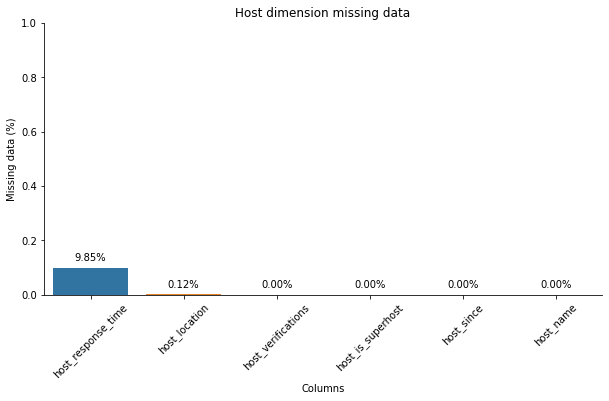

In [76]:
columns = [
'host_name',
'host_since',
'host_location',
'host_response_time',
'host_is_superhost',
'host_verifications'
]
ax = missing_data(df,columns)
set_bar_amount(ax)
ax.set_xlabel('Columns')
ax.set_ylabel('Missing data (%)')
plt.ylim(0,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Host dimension missing data')

Looking at the missing data we realize that it's reasonable to ignore the records of hosts lacking `location`, since it only corresponds to 0.12% of the whole dataset and the main focus of this analysis is based on the host's location. 

As for `response time`, we have 1691 missing values. Paradoxically, the fact that there isn't any information about whether the host is accessible is actually informative in some sense. Thus, all records lacking host_response_time values will be considered as if the response time is "Unknown".



## Transformation methods

In [77]:
# Check for missing values:
def is_nan(x):
    return (x != x)

In [78]:
def get_host_name(name):
    #If there is a name, return it
    if is_nan(name): return "Unknown"
    return name

In [79]:
def get_host_membership_duration(date):
    #date is a string with the date as YYYY-MM-DD

    if is_nan(date): return "Unknown"
    #get current year
    now = datetime.datetime.now()
    
    #calculate membership duration
    membership_time = now.year - int(date[0:4])
    if membership_time > 10: return "Member for more than 10 years"
    if membership_time > 5: return "Member for more than 5 years"
    if membership_time > 2: return "Member for more than 2 years"
    if membership_time >= 1: return "Member for more than 1 year"
    if membership_time < 1: return "Member for less than 1 year"

As we discussed previously, all host records who don't have a known location will be ignored - `None` lines will be later removed in preprocessing.

In [80]:
def get_host_country(location):
    #location is a string with the host location -- may not have country
    location = str(location)
    if re.search('po.*tugal', location, re.IGNORECASE): return "Portugal"
    if re.search('lisbo', location, re.IGNORECASE): return "Portugal"
    if re.search('PT', location): return "Portugal"
    if re.search('spain', location, re.IGNORECASE): return "Spain"
    if re.search('ES', location): return "Spain"
    if re.search('madrid', location, re.IGNORECASE): return "Spain"
    if re.search('united kingdom', location, re.IGNORECASE): return "United Kingdom"
    if re.search('UK', location): return "United Kingdom"
    if re.search('GB', location): return "United Kingdom"
    if re.search('ireland', location, re.IGNORECASE): return "United Kingdom"
    if re.search('denmark', location, re.IGNORECASE): return "Denmark"
    if re.search('netherlands', location, re.IGNORECASE): return "Netherlands"
    if re.search('NL', location): return "Netherlands"
    if re.search('germany', location, re.IGNORECASE): return "Germany"
    if re.search('DE', location): return "Germany"
    if re.search('belgium', location, re.IGNORECASE): return "Belgium"
    if re.search('united states', location, re.IGNORECASE): return "United States"
    if re.search('US', location): return "United States"
    if re.search('canada', location, re.IGNORECASE): return "Canada"
    if re.search('france', location, re.IGNORECASE): return "France"
    if re.search('FR', location): return "France"
    if re.search('italy', location, re.IGNORECASE): return "Italy"
    if re.search('IT', location): return "Italy"
    if re.search('switzerland', location, re.IGNORECASE): return "Switzerland"
    if re.search('sweden', location, re.IGNORECASE): return "Sweden"
    if re.search('poland', location, re.IGNORECASE): return "Poland"
    if re.search('finland', location, re.IGNORECASE): return "Finland"
    if re.search('serbia', location, re.IGNORECASE): return "Serbia"
    if re.search('austria', location, re.IGNORECASE): return "Austria"
    if re.search('iceland', location, re.IGNORECASE): return "Iceland"
    if re.search('norway', location, re.IGNORECASE): return "Norway"
    if re.search('china', location, re.IGNORECASE): return "China"
    if re.search('angola', location, re.IGNORECASE): return "Angola"
    if re.search('australia', location, re.IGNORECASE): return "Australia"
    if re.search('brazil', location, re.IGNORECASE): return "Brazil"
    if re.search('BR', location): return "Brazil"
    if re.search('peru', location, re.IGNORECASE): return "Peru"
    if re.search('sri lanka', location, re.IGNORECASE): return "Sri Lanka"
    if re.search('vietnam', location, re.IGNORECASE): return "Vietnam"
    if re.search('united arab emirates', location, re.IGNORECASE): return "United Arab Emirates"
    if re.search('south africa', location, re.IGNORECASE): return "South Africa"
    if re.search('qatar', location, re.IGNORECASE): return "Qatar"
    if re.search('japan', location, re.IGNORECASE): return "Japan"
    if re.search('turkey', location, re.IGNORECASE): return "Turkey"
    else: return None

One thing to keep in mind is that this method for identification of the host's country is not the most adequate, since it is not very generalizable to new data. In order for this method to work safely for all new data, an extended 'database' of countries would be needed. Here we made an effort to cover the most common countries in the dataset, but did not extend it much in order to preserve performance.

One alternative that we pursued was using the `pycountry` library, but since it was very inefficient (for each record it would go through all countries in the library!) we decided that for the purpose of this work the method above would be satisfatory.

In [81]:
def get_host_continent(country):
    if country == None: return None
    
    continents_dic = {
    'EU': 'Europe',
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    }
    
    # Acquire the country code
    country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
    # Convert country code to continent code; use dictionary to return continent name
    continent_name = pc.country_alpha2_to_continent_code(country_code)
    
    return continents_dic[continent_name]

In [82]:
def get_host_country_gdp(country):
    if country == None: return None
    
    # Always get latest (most updated) gdp available in the gdp dataset - last column
    # The level of detail required here is not very high, since we will use bins
    # to characterize the countries' wealth
    dict_gdp = pd.Series(df_gdp.iloc[:,-1].values, index=df_gdp['Country Name']).to_dict()
    
    if country not in dict_gdp.keys(): return "Unknown"
    
    gdp = dict_gdp[country]
    if gdp <= 20000  : return "Below 20k"
    if gdp <= 35000  : return "20k - 35k"
    if gdp <= 50000  : return "35k - 50k"
    if gdp > 50000 : return "Above 50k"
    else: return None

In [83]:
def get_host_response_time(response_time):
    #if there is a response_time, return it
    if is_nan(response_time): return "Unknown"
    return response_time

In [84]:
def get_host_is_superhost(is_superhost):
    if is_superhost == 't': return "Superhost"
    if is_superhost == 'f': return "Not Superhost"
    else: return None

In [85]:
def get_host_identity_verified(identity):
    if identity == 't': return "Verified"
    if identity == 'f': return "Unverified"
    else: return None

### Create clean dataframe

We will now use the methods described above to create each column of the dimension, extracting the data from the original dataset `df`.

In [86]:
listing_id = [i for i in df['id']]
host_id = [h for h in df['host_id']]
names = [n for n in df['host_name']]
membership_duration = [get_host_membership_duration(d) for d in df['host_since']]
country = [get_host_country(l) for l in df['host_location']]
continent = [get_host_continent(c) for c in country]
gdp = [get_host_country_gdp(c) for c in country]
response_time = [get_host_response_time(t) for t in df['host_response_time']]
superhost = [get_host_is_superhost(b) for b in df['host_is_superhost']]
identity_verified = [get_host_identity_verified(i) for i in df['host_identity_verified']]

In [87]:
columns = ['listing_id','host_id','host_name', 'membership_duration','host_country', 'host_continent', 
           'host_country_gdp', 'host_response_time', 'host_is_superhost', 'host_is_verified']

# Create dataframe
df_host_dimension = pd.DataFrame(np.stack((listing_id, host_id, names, membership_duration, country, 
                                           continent, gdp, response_time, superhost, 
                                           identity_verified),axis=-1), columns = columns)
# Dataframe shape (rows, columns)
df_host_dimension.shape

(17168, 10)

**Remove records with null values:**

In [88]:
def delete_null_rows(df,columns):
    """Removes all records with any empty cells from input DataFrame"""
    processed_df = df[columns].copy()
    total_rows = processed_df.shape[0]
    delete_rows = []
    
    if processed_df.isnull().values.any(): # if there are any null values in DataFrame, process DataFrame
        for index, row in enumerate(processed_df.itertuples(), start = 0):
            if (pd.Series(row).isnull().values.any()): # if row has any null value
                delete_rows.append(index) # add row index to delete list
    
    processed_df.drop(df.index[delete_rows], inplace = True) # delete rows fr
    processed_df = processed_df.reset_index().drop('index', axis = 1)
    print('DataFrame contains {} rows. Deleted {} rows ({}% of total rows)'.format(processed_df.shape[0], len(delete_rows), round(len(delete_rows)*100/total_rows, 2)))
    return processed_df

In [89]:
df_host_dimension = delete_null_rows(df_host_dimension, columns)

DataFrame contains 17005 rows. Deleted 163 rows (0.95% of total rows)


**Remove duplicates:**

In [90]:
columns = ['host_id','host_name', 'membership_duration','host_country', 'host_continent', 
           'host_country_gdp', 'host_response_time', 'host_is_superhost', 'host_is_verified']

host_dimension_processed = df_host_dimension[columns]
host_dimension_processed = host_dimension_processed.drop_duplicates()
host_dimension_processed = host_dimension_processed.reset_index().drop('index', axis = 1)
host_dimension_processed.index += 1

host_dimension_processed.head()

,host_id,host_name,membership_duration,host_country,host_continent,host_country_gdp,host_response_time,host_is_superhost,host_is_verified
1,107347,Ellie,Member for more than 5 years,United States,North America,Above 50k,within an hour,Superhost,Verified
2,125768,Bárbara,Member for more than 5 years,Portugal,Europe,20k - 35k,within an hour,Not Superhost,Unverified
3,126415,Mónica,Member for more than 5 years,Portugal,Europe,20k - 35k,within an hour,Not Superhost,Unverified
4,128075,Francisco,Member for more than 5 years,Portugal,Europe,20k - 35k,within a day,Superhost,Verified
5,128890,Sara,Member for more than 5 years,United States,North America,Above 50k,within a day,Not Superhost,Verified


Save final ETL product to .csv file:

In [119]:
host_dimension_processed.to_csv('../processed_dt/df_host_processed.csv',index=False)

## Attributing dimension keys to facts

We have a one-to-many relationship between `host ids` and `listing ids`. We create this 'mapping' table to keep track of the relationship between each fact in the fact table (PK - listing_id) and its respective host (FK - host_id).

In [92]:
df_mapping = pd.DataFrame(columns=['listing_id', 'host_id'])
df_mapping['listing_id'] = df_host_dimension['listing_id']
df_mapping['host_id'] = df_host_dimension['host_id']

df_mapping.head()

,listing_id,host_id
0,25659,107347
1,29248,125768
2,29396,126415
3,29720,128075
4,27899698,128075


Save mapping to .csv file:

In [122]:
df_mapping.to_csv('../processed_dt/df_listings_host.csv')

### Load Host dimension

Load database connection settings

In [17]:
from db_connection import dbconnection 

Test connection

In [18]:
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)
conn.close()

**Create or delete dimension**

In [ ]:
delete_table = """
DROP TABLE IF EXISTS Host CASCADE;
"""

create_table = """
CREATE TABLE Host (
    HOST_ID INT PRIMARY KEY NOT NULL,
    HOST_NAME VARCHAR(40) NOT NULL,
    MEMBERSHIP_DURATION VARCHAR(40) CHECK (MEMBERSHIP_DURATION in ('Member for more than 10 years','Member for more than 5 years','Member for more than 2 years','Member for more than 1 year','Member for less than 1 year', 'Unknown')) NOT NULL,
    HOST_COUNTRY VARCHAR(20) NOT NULL,
    HOST_CONTINENT VARCHAR(20) CHECK (HOST_CONTINENT in ('Europe','North America','South America','Asia','Australia','Africa')) NOT NULL,
    HOST_COUNTRY_GDP VARCHAR(20) CHECK (HOST_COUNTRY_GDP in ('Below 20k','20k - 35k','35k - 50k','Above 50k')) NOT NULL,
    HOST_RESPONSE_TIME VARCHAR(20) CHECK (HOST_RESPONSE_TIME in ('within an hour','within a few hours','within a day','a few days or more','Unknown')) NOT NULL,
    HOST_IS_SUPERHOST VARCHAR(20) CHECK (HOST_IS_SUPERHOST in ('Superhost','Not Superhost')) NOT NULL,
    HOST_IS_VERIFIED VARCHAR(20) CHECK (HOST_IS_VERIFIED in ('Verified','Unverified')) NOT NULL
    )
"""

In [ ]:
def excuteSingleSQLstatement(sql, host, database, user, password,gssencmode):
    conn = pg.connect(host=host,database=database, user=user, password=password,sslmode = sslmode,gssencmode=gssencmode)
    cur = conn.cursor()
    cur.execute(sql)
    cur.close()
    conn.commit()
    conn.close()    

In [ ]:
#excuteSingleSQLstatement(delete_table, dbconnection.server_host, dbconnection.dbname, dbconnection.dbusername, dbconnection.dbpassword,gssencmode = dbconnection.gssencmode)
#excuteSingleSQLstatement(create_table, dbconnection.server_host, dbconnection.dbname, dbconnection.dbusername, dbconnection.dbpassword,gssencmode = dbconnection.gssencmode)

**Inserting the data**

We will be inserting the data from the dataframe `host_dimension_processed`, but first checking whether that information is already in the database.

In [22]:
# Useful methods

def query_table(conn, table_name):
    """Returns DataFrame with queried database table"""
    sql = "select * from {}".format(table_name)
    #return dataframe
    return sqlio.read_sql_query(sql, conn)

def get_data_to_insert(df1, df2, columns):
    #Check if data of df1's given columns is in df2
    #Only works if df1 and df2 have the same columns
    return df1[~df1[columns].apply(tuple,1).isin(df2[columns].apply(tuple,1))]

def insert_data(df, table_name, conn):
    # Method for bulk insert
    df_columns = list(df)
    columns = ",".join(df_columns)
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 
    insert_stmt = "INSERT INTO {} ({}) {}".format(table_name,columns,values)
    success = True
    try:
        cursor = conn.cursor()
        pg.extras.execute_batch(cursor, insert_stmt, df.values)
        conn.commit()
        success = True
    except pg.DatabaseError as error:
        success = False
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return success

1. Query Database

In [ ]:
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)
df_sql = query_table(conn, 'Host')
conn.close()
df_sql.drop(['host_id'], axis=1, inplace=True)
df_sql.head()

2. Cross-Validate if data exists on DB

In [24]:
# Boolean switch: True if we want to load data from .csv file
use_csv_data = True

if use_csv_data: 
    host_dimension_processed = pd.read_csv("../processed_dt/df_host_processed.csv").drop(['Unnamed: 0'],axis=1)

host.head()

,host_id,host_name,membership_duration,host_country,host_continent,host_country_gdp,host_response_time,host_is_superhost,host_is_verified
0,107347,Ellie,Member for more than 5 years,United States,North America,Above 50k,within an hour,Superhost,Verified
1,125768,Bárbara,Member for more than 5 years,Portugal,Europe,20k - 35k,within an hour,Not Superhost,Unverified
2,126415,Mónica,Member for more than 5 years,Portugal,Europe,20k - 35k,within an hour,Not Superhost,Unverified
3,128075,Francisco,Member for more than 5 years,Portugal,Europe,20k - 35k,within a day,Superhost,Verified
4,128890,Sara,Member for more than 5 years,United States,North America,Above 50k,within a day,Not Superhost,Verified
...,...,...,...,...,...,...,...,...,...
6860,16502648,Alexander,Member for more than 5 years,Portugal,Europe,20k - 35k,within a day,Not Superhost,Unverified
6861,330201893,Gonçalo,Member for less than 1 year,Portugal,Europe,20k - 35k,Unknown,Not Superhost,Unverified
6862,330234500,Margarida,Member for less than 1 year,Portugal,Europe,20k - 35k,Unknown,Not Superhost,Unverified
6863,121821289,Hugo,Member for more than 2 years,Portugal,Europe,20k - 35k,Unknown,Not Superhost,Unverified


In [29]:
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)
df_sql = query_table(conn, 'host')
conn.close()
df_sql.head()

,host_id,host_name,membership_duration,host_country,host_continent,host_country_gdp,host_response_time,host_is_superhost,host_is_verified


In [30]:
columns = ['host_name', 'membership_duration','host_country', 'host_continent', 
           'host_country_gdp', 'host_response_time', 'host_is_superhost', 'host_is_verified']

df_etl = get_data_to_insert(host_dimension_processed, df_sql, columns=columns)
df_etl.head()

,host_id,host_name,membership_duration,host_country,host_continent,host_country_gdp,host_response_time,host_is_superhost,host_is_verified
0,107347,Ellie,Member for more than 5 years,United States,North America,Above 50k,within an hour,Superhost,Verified
1,125768,Bárbara,Member for more than 5 years,Portugal,Europe,20k - 35k,within an hour,Not Superhost,Unverified
2,126415,Mónica,Member for more than 5 years,Portugal,Europe,20k - 35k,within an hour,Not Superhost,Unverified
3,128075,Francisco,Member for more than 5 years,Portugal,Europe,20k - 35k,within a day,Superhost,Verified
4,128890,Sara,Member for more than 5 years,United States,North America,Above 50k,within a day,Not Superhost,Verified


In [31]:
df_etl.shape

(6865, 9)

3. Insert new data

In [32]:
if len(df_etl) > 0:
    table_name = 'Host'
    conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)
    success = insert_data(df_etl,table_name, conn)
    conn.close()
    if success == True: print('Data inserted succefully')
else: print('No data to insert')

Data inserted succefully


## Critical assesment of the work

As discussed before the main problem with this ETL is that it might not be able to generalize to new data. The extraction of the host location is a difficult task, since the data is very heterogenous. One way to go around this could probably be to have the host fill in a form at the moment of registration with fixed slots for county, district, city, country, etc. That would also greatly facilitate the pre-processing and make it more reproducible.

In respect of loading, the method for crossvalidating is also not perfect. We check the database for identical tuples to those we are trying to insert, but ignore the `host_id`. If we were to insert a record with a `host_id` already in the database, but one altered element of the tuple, we wouldn't categorize that as data already in the DB and we would later have a primary-key contraint problem. One way of fixing this has to do with how we would handle this slow changing dimension (see bellow) - adding a surrogate key and including `host_id` in the search.

#### Slow changing dimensions

The data in this dimension is expected to change over time, not on daily basis, but once in a while or periodically. In these sense, we need to create strategies to deal with the new data, and assess the importance of keeping history of these changes.

The `membership_duration` is a field that would need to be updated every year, or every few years. Since the membership duration is cumulative, i.e. the fact that one is a member for 5 years implies that he is a member for 1, 2, ... years as well, means that we could employ a type 1 method for this SCD: just replace the previous value, without keeping history.

The fields referring to the host location (`host_country`, `host_continent`, `host_country_gdp`) could also require updating since hosts can change their home location. It is then important to assess if keeping a history of these changes is relevant for the types of analysis that will be done. In our point of view, it is not relevant to keep this history, since the host location is not properly a key factor when choosing a house for booking. Questions of the type "did boking increase after the host changed country?" do not seem relevant.
In this sense we suggest once again the type 1 method for SCD: just replace the previous value, without keeping history. Of course, the necessity of keeping history would have to be discussed with the decision makers, and in the case that , we would employ a type 2 method for SCD, which we will be better explained after.

On the other hand, we think that it would be interesting to keep a history of the fields `host_response_time`, `host_is_superhost` and `host_is_verified`, since these could directly correlate with the number of bookings.  We could analyse, for instance, if there are more bookings after the host was verified or became more responsive or superhost. Keeping this history allows us to perceive the weight of these host's characteristics in the user's choice of booking.

Thus, we propose this dimension as a type 2 SCD: adding a new line to the dimension each time a change is made.

![Type 2 SCD](../images/SCD_type_2_host.png)

We would need to add four new columns:
 - host_key, which is a surrogate key 
 - row effective date, which is the date in which that row first appeared
 - row expiration date, which is the date in which that row becomes outdated
 - current row indicator, which indicates if that row is the current one of if it is part of the history
 
One disadvantage of this method is that it accelerates the growth of the host dimension table, potentially becoming a 'monster dimension'. We could consider that the growing of the table would not be so massive, since:
 - `host_is_superhost` and `host_is_verified` only have two possible states and they are likely to change only once;
 - hosts do not change their location often;
 - `host_response_time` could be something updated only very periodically.